# Plant Pathology 2020 - FGVC7
---
Identify the category of foliar diseases in apple trees

In [28]:
from fastai2.vision.all import *
from fastai2.callback.fp16 import *

## Get the data

In [8]:
path = Path('fastai-experiments/plant-pathology/data/')
path.ls()

(#6) [Path('fastai-experiments/plant-pathology/data/train.csv'),Path('fastai-experiments/plant-pathology/data/.ipynb_checkpoints'),Path('fastai-experiments/plant-pathology/data/test.csv'),Path('fastai-experiments/plant-pathology/data/sample_submission.csv'),Path('fastai-experiments/plant-pathology/data/.gitignore'),Path('fastai-experiments/plant-pathology/data/images')]

In [9]:
Path.BASE_PATH = path

In [10]:
path.ls()

(#6) [Path('train.csv'),Path('.ipynb_checkpoints'),Path('test.csv'),Path('sample_submission.csv'),Path('.gitignore'),Path('images')]

In [11]:
(path/'images').ls()

(#3642) [Path('images/Test_1746.jpg'),Path('images/Train_711.jpg'),Path('images/Test_1571.jpg'),Path('images/Test_1759.jpg'),Path('images/Train_678.jpg'),Path('images/Test_407.jpg'),Path('images/Train_129.jpg'),Path('images/Test_376.jpg'),Path('images/Test_546.jpg'),Path('images/Train_1704.jpg')...]

## Create Datasets and DataLoaders

In [12]:
df = pd.read_csv(path/'train.csv')
df.head()

,image_id,healthy,multiple_diseases,rust,scab
0,Train_0,0,0,0,1
1,Train_1,0,1,0,0
2,Train_2,1,0,0,0
3,Train_3,0,0,1,0
4,Train_4,1,0,0,0


In [13]:
# select the file names
df['image_id']

0          Train_0
1          Train_1
2          Train_2
3          Train_3
4          Train_4
           ...    
1816    Train_1816
1817    Train_1817
1818    Train_1818
1819    Train_1819
1820    Train_1820
Name: image_id, Length: 1821, dtype: object

In [14]:
df['image_id'][0]

'Train_0'

In [15]:
# select only the labels
df.iloc[:,1:]

,healthy,multiple_diseases,rust,scab
0,0,0,0,1
1,0,1,0,0
2,1,0,0,0
3,0,0,1,0
4,1,0,0,0
...,...,...,...,...
1816,0,0,0,1
1817,1,0,0,0
1818,1,0,0,0
1819,0,0,1,0


Create datablock

In [16]:
db = DataBlock()

In [17]:
ds = db.datasets(df)

In [18]:
ds.train[0]

(image_id             Train_462
 healthy                      0
 multiple_diseases            0
 rust                         1
 scab                         0
 Name: 462, dtype: object,
 image_id             Train_462
 healthy                      0
 multiple_diseases            0
 rust                         1
 scab                         0
 Name: 462, dtype: object)

In [19]:
def get_x(r): return path/'images'/f'{r["image_id"]}.jpg'
def get_y(r): return list(r.loc[r==1].index)

db = DataBlock(get_x=get_x,
               get_y=get_y)

In [20]:
ds = db.datasets(df)

In [21]:
ds.train[0]

(Path('images/Train_1579.jpg'), ['rust'])

Good so now we're getting the right path and labels, let's specify that we're are working with images

In [22]:
db = DataBlock(blocks=(ImageBlock, MultiCategoryBlock),
               get_x=get_x,
               get_y=get_y)

In [23]:
ds = db.datasets(df)
ds.train[0]

(PILImage mode=RGB size=2048x1365, TensorMultiCategory([1., 0., 0., 0.]))

In [25]:
def get_dls(size, bs):
    db = DataBlock(blocks=(ImageBlock, MultiCategoryBlock),
                   get_x=get_x,
                   get_y=get_y,
                   splitter=RandomSplitter(seed=42),
                   item_tfms=Resize(460),
                   batch_tfms=aug_transforms(size=size, flip_vert=True, min_scale=0.75))
    return db.dataloaders(df, bs=bs)

In [26]:
dls = get_dls(128, 128)

Let's have a look at the data

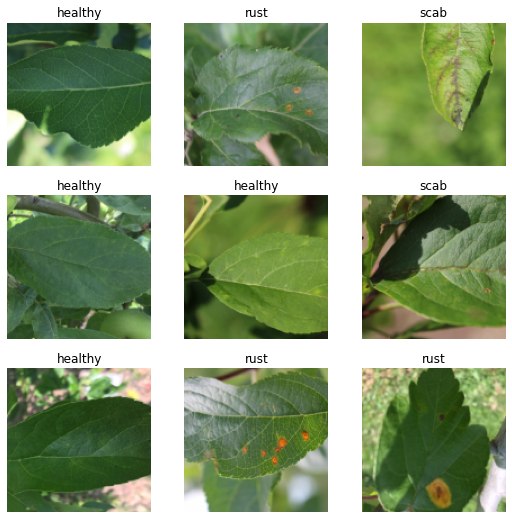

In [27]:
dls.show_batch(max_n=9)

## Build model on 128x128 images

In [29]:
learn = cnn_learner(dls, resnet152,
                    metrics=partial(accuracy_multi, thresh=0.6)).to_fp16()

Downloading: "https://download.pytorch.org/models/resnet152-b121ed2d.pth" to /home/jupyter/.cache/torch/checkpoints/resnet152-b121ed2d.pth


In [30]:
learn.fine_tune(10, freeze_epochs=5)

epoch,train_loss,valid_loss,accuracy_multi,time
0,0.985127,0.617893,0.734890,00:31
1,0.821010,0.545139,0.791896,00:24
2,0.729824,0.536546,0.819368,00:23
3,0.650445,0.482994,0.842720,00:23
4,0.579170,0.419136,0.875000,00:23


epoch,train_loss,valid_loss,accuracy_multi,time
0,0.357443,0.374564,0.890797,00:25
1,0.327030,0.273727,0.934066,00:26
2,0.285896,0.246401,0.940247,00:25
3,0.254317,0.222930,0.943681,00:25
4,0.226853,0.190906,0.956731,00:25
5,0.205041,0.176973,0.961538,00:25
6,0.184483,0.176473,0.960165,00:26
7,0.164876,0.168227,0.960165,00:26
8,0.149059,0.165055,0.959478,00:26
9,0.136777,0.165449,0.958791,00:25


## Scale up to 224x224 images

In [31]:
dls = get_dls(224, 64)

In [32]:
learn.dls = dls

In [33]:
xb, yb = learn.dls.train.one_batch()
xb.shape, yb.shape

(torch.Size([64, 3, 224, 224]), torch.Size([64, 4]))

SuggestedLRs(lr_min=0.00010000000474974513, lr_steep=9.12010818865383e-07)

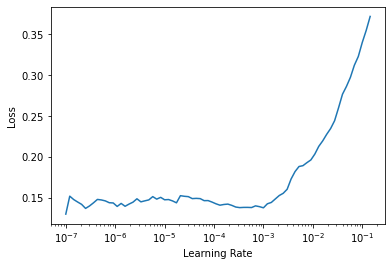

In [34]:
learn.lr_find()

In [36]:
learn.fine_tune(20, base_lr=1e-4, freeze_epochs=7)

epoch,train_loss,valid_loss,accuracy_multi,time
0,0.160397,0.196676,0.945055,00:26
1,0.151778,0.160320,0.960852,00:25
2,0.151674,0.156570,0.963599,00:25
3,0.148090,0.148509,0.963599,00:25
4,0.146040,0.144662,0.964286,00:25
5,0.138445,0.140263,0.963599,00:25
6,0.133496,0.140620,0.964286,00:25


epoch,train_loss,valid_loss,accuracy_multi,time
0,0.132936,0.139484,0.964286,00:32
1,0.120026,0.138410,0.966346,00:31
2,0.118957,0.132882,0.964286,00:31
3,0.114258,0.131632,0.962912,00:31
4,0.108220,0.126718,0.964973,00:32
5,0.105151,0.125832,0.964973,00:31
6,0.102293,0.126266,0.964973,00:31
7,0.098034,0.117196,0.966346,00:31
8,0.093728,0.116998,0.966346,00:31
9,0.091678,0.115280,0.969093,00:32


## Find right threshold

In [37]:
preds, targs = learn.get_preds()

In [38]:
xs = torch.linspace(0.05, 0.95, 29)
accs = [accuracy_multi(preds, targs, thresh=o, sigmoid=False) for o in xs]

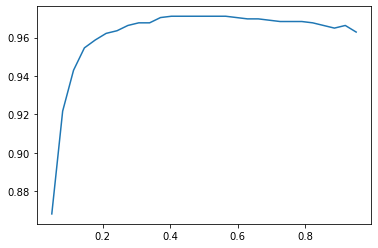

In [39]:
plt.plot(xs, accs)

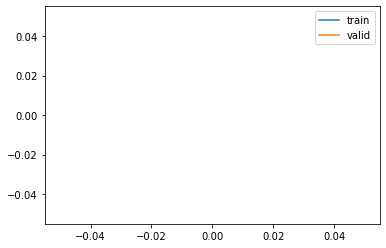

In [40]:
learn.recorder.plot_loss()

## Evaluate on test set

In [41]:
test_df = pd.read_csv(path/'test.csv')
test_df.head()

,image_id
0,Test_0
1,Test_1
2,Test_2
3,Test_3
4,Test_4


In [42]:
test_dl = learn.dls.test_dl(test_df, with_labels=False)

In [43]:
probs, classes = learn.get_preds(dl=test_dl)

In [44]:
probs.shape

torch.Size([1821, 4])

In [45]:
probs[0]

tensor([0.0241, 0.0746, 0.9999, 0.0037])

In [46]:
probs_df = pd.DataFrame(probs)

In [47]:
probs_df.head()

,0,1,2,3
0,0.024054,0.074635,0.999918,0.003736
1,0.008062,0.035145,0.999728,0.007907
2,0.003483,0.013274,0.001410,1.000000
3,1.000000,0.010288,0.000085,0.000040
4,0.002890,0.020100,1.000000,0.000446


In [48]:
learn.dls.vocab

(#4) ['healthy','multiple_diseases','rust','scab']

In [49]:
probs_df.columns = learn.dls.vocab

In [50]:
probs_df.head()

,healthy,multiple_diseases,rust,scab
0,0.024054,0.074635,0.999918,0.003736
1,0.008062,0.035145,0.999728,0.007907
2,0.003483,0.013274,0.001410,1.000000
3,1.000000,0.010288,0.000085,0.000040
4,0.002890,0.020100,1.000000,0.000446


In [51]:
combined = pd.concat([test_df, probs_df], axis=1)
combined

,image_id,healthy,multiple_diseases,rust,scab
0,Test_0,0.024054,0.074635,0.999918,0.003736
1,Test_1,0.008062,0.035145,0.999728,0.007907
2,Test_2,0.003483,0.013274,0.001410,1.000000
3,Test_3,1.000000,0.010288,0.000085,0.000040
4,Test_4,0.002890,0.020100,1.000000,0.000446
...,...,...,...,...,...
1816,Test_1816,0.004265,0.029036,1.000000,0.000981
1817,Test_1817,0.018160,0.234056,0.000940,0.572305
1818,Test_1818,0.019947,0.099295,0.991118,0.001160
1819,Test_1819,1.000000,0.047691,0.000473,0.003854


export predictions to a csv file

In [52]:
combined.to_csv('third.csv', index=False)